GOAL: Calculate linear distance from start to end point for every trip in 2022

    Since Divvy does not provide data about the distance traveled in each trip, I will calculate the linear distance of the starting and ending location. 

    1. Load SQL Trips Table into Dataframe and transform to GeoDataFrame
    2. Create a shapelly Linestring that connects the start and endpoint
    3. Calculate the length of each Linestring
    4. Basic visualization (Distribution of linear distances of all Trips)

In [1]:
# pandas
import pandas as pd

# additional import of the geopandas package
import geopandas as gpd

# numpy
import numpy as np

# import mathplotlib.pyplot as plt
import matplotlib.pyplot as plt

# shapely.geometry      Package shapely.geomerty is usefull to for checking, whether a point is inside a polygon and converting string type
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point, MultiLineString

# importing self made functions from sql_functions script
import sql_functions as sf

## 1. Loading Trips 2022 (see notebook 02_merge_areas_trips_data.ipynb) from SQL Database and transform to GeoDataFrame

In [2]:
# Schemaname
schema = "capstone_divvy_bikeshare"

In [3]:
# Loading Table 2022_v4 from SQL into dataframe
#df_trips_2022 = sf.get_dataframe(f"select * from {schema}.trips_2022_v4")
df_trips_2022 = sf.get_dataframe(f"SELECT ride_id, start_point, end_point, start_area_number, end_area_number, start_community_name, end_community_name  From {schema}.trips_2022_v4")

In [4]:
df_trips_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540772 entries, 0 to 5540771
Data columns (total 7 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ride_id               object
 1   start_point           object
 2   end_point             object
 3   start_area_number     int64 
 4   end_area_number       int64 
 5   start_community_name  object
 6   end_community_name    object
dtypes: int64(2), object(5)
memory usage: 295.9+ MB


Transforming to GeoDataFrame: by Using "to_gdf_new(")", defined in the "sql_functions.py" script.

In [5]:
# converting start_point column to shapely geometry creating geodataframe crs = "WGS 84"
gdf_trips_2022 = sf.to_gdf_new(df_trips_2022, geometry_column="start_point")    
# converting end_point column to shapely geometry and creating geodataframe crs = "WGS 84"
gdf_trips_2022 = sf.to_gdf_new(gdf_trips_2022, geometry_column="end_point")

As we can see, we created a GeoDataFrame with two geometry columns:

In [6]:
gdf_trips_2022.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5540772 entries, 0 to 5540771
Data columns (total 7 columns):
 #   Column                Dtype   
---  ------                -----   
 0   ride_id               object  
 1   start_point           geometry
 2   end_point             geometry
 3   start_area_number     int64   
 4   end_area_number       int64   
 5   start_community_name  object  
 6   end_community_name    object  
dtypes: geometry(2), int64(2), object(3)
memory usage: 295.9+ MB


## 2. Create a shapely Linestring Object that connects the start and endpoint

#### PYPROJ: Lets calculate the distance/ Length of a Linestring in meters, by  using the pyproj package:
    * Source: https://pyproj4.github.io/pyproj/stable/api/geod.html#pyproj.Geod.geometry_length
    * This Package allows us to calculate the length of shapely geometries in meters
    * For this use the Function:    geometry_length(geometry, radians: bool = False) → float[source]

In [7]:
# Importing pyproj package, to define an ellipsoid
from pyproj import Geod

Creating a shapely LineString object for a specific trip:

In [19]:
# Calculating the length of the first Trip in the dataset: index number 1
line_string = LineString([gdf_trips_2022["start_point"][1],gdf_trips_2022["end_point"][1]])   

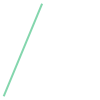

In [28]:
line_string

Defining Ellipsoid

In [29]:
geod = Geod(ellps="WGS84")                  # what kind of ellipsoid do you use? Initialize a Geod class instance

Calculating Linear Distance in meters

In [30]:
geod.geometry_length(line_string)           # Applying geometry_length function on Ellipsoid
                                            # ---> the airdistance between starting an ending location is x Meters...

1265.1615195241993

#### Adding Column with the Linestring geometry for every trip:

In [32]:
# Adding a Linestring geometry to every trip, for the direct way (direct connection) between start and endpoint:
gdf_trips_2022["linestring"] = [LineString([gdf_trips_2022["start_point"][i],gdf_trips_2022["end_point"][i]]) for i in gdf_trips_2022.index]

In [ ]:
gdf_trips_2022["linestring"].sample(1000).explore()

In [33]:
gdf_trips_2022.head(3)

,ride_id,start_point,end_point,start_area_number,end_area_number,start_community_name,end_community_name,linestring
0,0F5A862EB08884FF,POINT (-87.62209 41.89058),POINT (-87.63844 41.89467),8,8,Near North Side,Near North Side,"LINESTRING (-87.622086 41.890577, -87.638437 4..."
1,285E25EA6F0D6445,POINT (-87.61000 41.81000),POINT (-87.60000 41.81000),38,39,Grand Boulevard,Kenwood,"LINESTRING (-87.61 41.81, -87.59999999999999 4..."
2,CD1B644C9A96A572,POINT (-87.66146 41.87219),POINT (-87.65695 41.88307),28,28,Near West Side,Near West Side,"LINESTRING (-87.661464 41.872193, -87.656952 4..."


#### Adding Column with the linear distance between start and end point to DataFrame:

In [34]:
#  calculation length of every LineString and storing it in column "airdistance_meters" 
gdf_trips_2022["airdistance_meters"] = [geod.geometry_length(gdf_trips_2022["linestring"][i]) for i in gdf_trips_2022.index]

In [35]:
gdf_trips_2022.head(3)

,ride_id,start_point,end_point,start_area_number,end_area_number,start_community_name,end_community_name,linestring,airdistance_meters
0,0F5A862EB08884FF,POINT (-87.62209 41.89058),POINT (-87.63844 41.89467),8,8,Near North Side,Near North Side,"LINESTRING (-87.622086 41.890577, -87.638437 4...",1430.955075
1,285E25EA6F0D6445,POINT (-87.61000 41.81000),POINT (-87.60000 41.81000),38,39,Grand Boulevard,Kenwood,"LINESTRING (-87.61 41.81, -87.59999999999999 4...",830.967660
2,CD1B644C9A96A572,POINT (-87.66146 41.87219),POINT (-87.65695 41.88307),28,28,Near West Side,Near West Side,"LINESTRING (-87.661464 41.872193, -87.656952 4...",1265.161520


## Some basic Visualizations on airdistance.

In [40]:
# importing seaborn for some basic visualizations:
import seaborn as sns

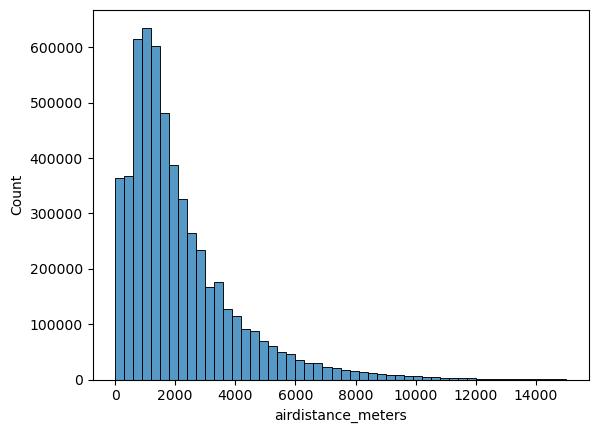

In [52]:
sns.histplot(data=gdf_trips_2022, x="airdistance_meters",binrange=(0, 15000), bins=50);